In [2]:
# Import key libraries
import torch
import torch.nn as nn
import torch.nn.functional as Func
from torch.autograd import Variable
import torch.optim as optim
import torch.utils.data as data
import random
from scipy.io import savemat
import os
from os import path
from sklearn.preprocessing import normalize
from torch.nn.utils import clip_grad_norm_
import torch.nn.parallel.data_parallel as data_parallel
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch
from sklearn.datasets import fetch_openml
from sklearn.model_selection import StratifiedShuffleSplit
import collections
from torch.utils.data import Dataset
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns


### Loading and preprocessing the dataset

In [3]:
mnist = fetch_openml('mnist_784', version=1)  # Load MNIST data
X, y = mnist["data"], mnist["target"]
y = y.astype(int)  # Convert labels to integers

In [4]:
# Normalize X to have values between -1 and 1
X = ((X / 255.) - .5) * 2

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Split the training dataset into training and validation sets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

for train_index, val_index in split.split(X_train, y_train):
    X_train_strat = X_train.iloc[train_index]
    y_train_strat = y_train.iloc[train_index]
    X_dev_strat = X_train.iloc[val_index]
    y_dev_strat = y_train.iloc[val_index]

# Print the shapes of the resulting arrays
print(X.shape, y.shape)
print(min(y), max(y))
print(type(X), type(y))
print(X_train_strat.shape, y_train_strat.shape)
print(X_dev_strat.shape, y_dev_strat.shape)

(70000, 784) (70000,)
0 9
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>
(54000, 784) (54000,)
(6000, 784) (6000,)


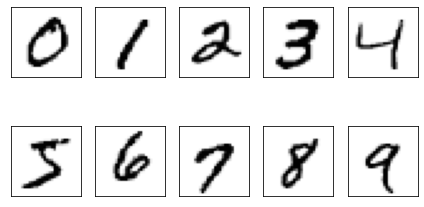

In [5]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y==i]
    ax[i].imshow(img.iloc[0].to_numpy().reshape(28, 28), cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

### torch dataset

In [6]:
class MyDataset(Dataset):
    def __init__(self, input_data, labels):
        if isinstance(input_data, pd.DataFrame) or isinstance(input_data, pd.Series):
            input_data = input_data.to_numpy()
        if isinstance(labels, pd.DataFrame) or isinstance(labels, pd.Series):
            labels = labels.to_numpy()

        self.feats = torch.tensor(input_data, dtype=torch.float32).view(-1, 1, 28, 28)  # Reshape for CNN
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return self.feats[index], self.labels[index]

    
params = {'batch_size': 50, 'shuffle': True}

training_set = MyDataset(X_train_strat, y_train_strat)
dev_set      = MyDataset(X_dev_strat  , y_dev_strat)
test_set     = MyDataset(X_test       , y_test)

train_loader = DataLoader(training_set, **params)
val_loader   = DataLoader(dev_set     , **params)
test_loader  = DataLoader(test_set    , **params)

### CNN Model

In [7]:
class CNN(nn.Module):
    def __init__(self,Dropout=0.25):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=3, stride=1)
        self.dropout1 = nn.Dropout(Dropout)  # Dropout after conv1
        self.conv2 = nn.Conv2d(6, 10, kernel_size=3, stride=1)
        self.dropout2 = nn.Dropout(Dropout)  # Dropout after conv2
        self.fc1 = nn.Linear(10 * 24 * 24, 10) 
        self.softmax = nn.Softmax(dim=1) 


        # Xavier initialization
        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.zeros_(self.conv1.bias)
        nn.init.xavier_uniform_(self.conv2.weight)
        nn.init.zeros_(self.conv2.bias)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.dropout1(x)  # Apply dropout after conv1
        x = F.relu(self.conv2(x))
        x = self.dropout2(x)  # Apply dropout after conv2
        
        # Flatten the output for the fully connected layer
        x = x.view(-1, 10 * 24 * 24)  
        x = self.fc1(x)
        #out = self.softmax(x) # Applying softmax in the forward method and then using a loss function that also applies softmax (like nn.CrossEntropyLoss) can lead to incorrect loss calculations.  
        return x


In [14]:
class EarlyStopping:
    def __init__(self, patience=7, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss):
        score = val_loss

        if self.best_score is None:
            self.best_score = score
        elif score > self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0


In [9]:
def train(model, device, loss_fcn, train_loader, optimizer):
    train_loss = 0
    correct = 0
    model.train(True)
    with torch.set_grad_enabled(True):
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            # opt initialization
            optimizer.zero_grad()
            # Model computation
            output = model(data)
            # Loss calculation
            loss = loss_fcn(output, target)
            train_loss += loss * data.size(0)
            # Backpropagation
            loss.backward()   # gradient calculation
            optimizer.step()  # weight update
            # model output
            output = model.softmax(output)
            pred = output.argmax(dim=1, keepdim=True)   
            correct += pred.eq(target.view_as(pred)).sum().item()
            
        train_loss /= len(train_loader.dataset)
        accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss, accuracy


In [10]:
def validate(model, device, loss_fcn, val_loader):
    val_loss = 0
    correct = 0
    model.eval()
    with torch.set_grad_enabled(False):    
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            # Model computation
            output = model(data)
            # Loss calculation
            loss = loss_fcn(output, target)
            val_loss += loss * data.size(0)
            # model output
            output = model.softmax(output)
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(val_loader.dataset)
    accuracy  = 100. * correct / len(val_loader.dataset)
    return val_loss, accuracy


Dropout 0.25

Epoch: 1, Training Loss: 0.2467, Validation Loss: 0.1316, Training Accuracy: 92.66%, Validation Accuracy: 96.25%
Epoch: 2, Training Loss: 0.1263, Validation Loss: 0.1180, Training Accuracy: 96.13%, Validation Accuracy: 96.48%
Epoch: 3, Training Loss: 0.1040, Validation Loss: 0.0743, Training Accuracy: 96.81%, Validation Accuracy: 97.95%
Epoch: 4, Training Loss: 0.0950, Validation Loss: 0.0901, Training Accuracy: 97.12%, Validation Accuracy: 97.67%
EarlyStopping counter: 1 out of 10
Epoch: 5, Training Loss: 0.0877, Validation Loss: 0.0915, Training Accuracy: 97.36%, Validation Accuracy: 97.33%
EarlyStopping counter: 2 out of 10
Epoch: 6, Training Loss: 0.0835, Validation Loss: 0.0951, Training Accuracy: 97.46%, Validation Accuracy: 97.27%
EarlyStopping counter: 3 out of 10
Epoch: 7, Training Loss: 0.0812, Validation Loss: 0.0916, Training Accuracy: 97.48%, Validation Accuracy: 97.70%
EarlyStopping counter: 4 out of 10
Epoch: 8, Training Loss: 0.0802, Validation Loss: 0.0754, Training Ac

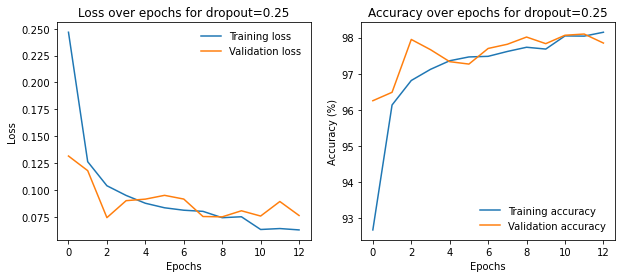

Test Accuracy: 97.77%


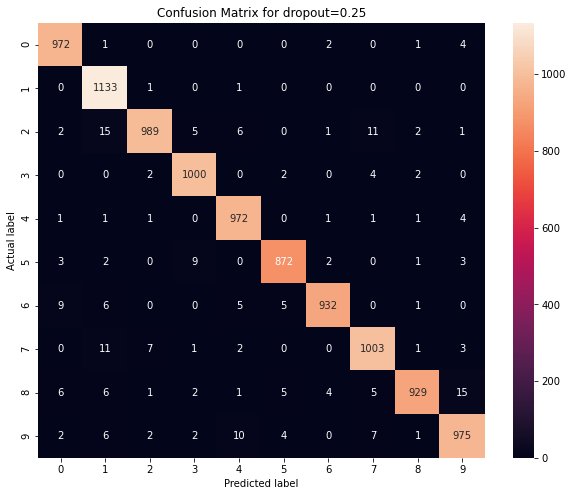

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN(Dropout=0.25).to(device)

optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.9)

early_stopping = EarlyStopping(patience=10)
loss = nn.CrossEntropyLoss()

train_losses     = []
val_losses       = []
train_accuracies = []
val_accuracies   = []
# Training loop
epochs = 100
for epoch in range(1, epochs + 1):
    train_loss, train_accuracy = train   (model, device, loss, train_loader, optimizer)
    val_loss, val_accuracy     = validate(model, device, loss, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f'Epoch: {epoch}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%')
    scheduler.step()
    
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break    


plt.figure(figsize=(10, 4))

# Plot for loss
plt.subplot(1, 2, 1)
plt.plot([i.detach().numpy() for i in train_losses], label='Training loss')
plt.plot([i.detach().numpy() for i in val_losses], label='Validation loss')
plt.legend(frameon=False)
plt.title('Loss over epochs for dropout=0.25')
plt.xlabel('Epochs')  # X-axis title
plt.ylabel('Loss')  # Y-axis title

# Plot for accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training accuracy')
plt.plot(val_accuracies, label='Validation accuracy')
plt.legend(frameon=False)
plt.title('Accuracy over epochs for dropout=0.25')
plt.xlabel('Epochs')  # X-axis title
plt.ylabel('Accuracy (%)')  # Y-axis title

plt.show()

# Test the model
test_loss, test_accuracy = validate(model, device, loss,  test_loader)
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Predictions and true labels
true_labels = []
pred_labels = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        output = model.softmax(output)
        pred = output.argmax(dim=1, keepdim=True).view_as(target)
        pred_labels.extend(pred.tolist())
        true_labels.extend(target.tolist())

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix for dropout=0.25')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# Results

By integrating a dropout  with a rate of 0.25, we observed a reduction in testing loss alongside an increase in accuracy. This implies that the model benefits from enhanced learning efficiency through the exclusion of a quarter of its neurons.

Furthermore, both training and validation losses exhibit a consistent downward trend, signaling continuous learning and performance enhancement across epochs. Notably, the elimination of the gap between validation and training losses indicates successful mitigation of overfitting. Additionally, the learning process has become more stable, with fewer fluctuations observed in the validation set.

Drop out 0.5

Epoch: 1, Training Loss: 0.4220, Validation Loss: 0.1895, Training Accuracy: 87.36%, Validation Accuracy: 94.60%
Epoch: 2, Training Loss: 0.3059, Validation Loss: 0.2450, Training Accuracy: 90.96%, Validation Accuracy: 93.67%
EarlyStopping counter: 1 out of 10
Epoch: 3, Training Loss: 0.2737, Validation Loss: 0.2226, Training Accuracy: 92.04%, Validation Accuracy: 93.85%
EarlyStopping counter: 2 out of 10
Epoch: 4, Training Loss: 0.2578, Validation Loss: 0.2410, Training Accuracy: 92.55%, Validation Accuracy: 93.40%
EarlyStopping counter: 3 out of 10
Epoch: 5, Training Loss: 0.2588, Validation Loss: 0.1758, Training Accuracy: 92.62%, Validation Accuracy: 94.58%
Epoch: 6, Training Loss: 0.2669, Validation Loss: 0.3635, Training Accuracy: 92.44%, Validation Accuracy: 89.55%
EarlyStopping counter: 1 out of 10
Epoch: 7, Training Loss: 0.2459, Validation Loss: 0.3256, Training Accuracy: 93.03%, Validation Accuracy: 91.40%
EarlyStopping counter: 2 out of 10
Epoch: 8, Training Loss: 0.2529, V

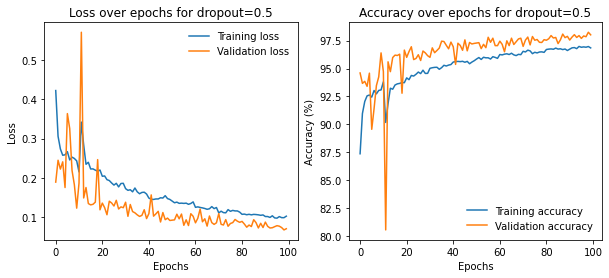

Test Accuracy: 98.14%


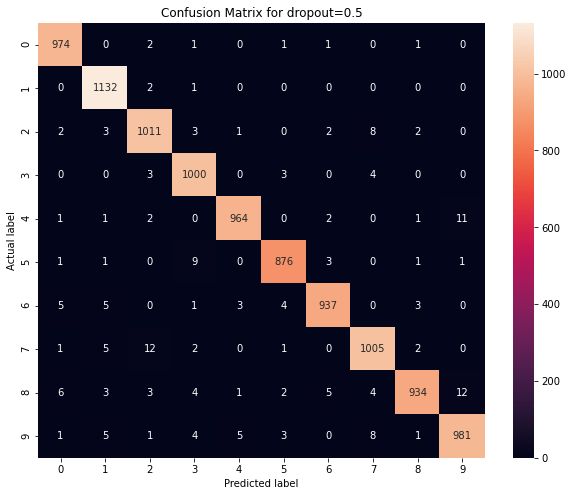

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN(Dropout=0.5).to(device)

optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.9)

early_stopping = EarlyStopping(patience=10)
loss = nn.CrossEntropyLoss()

train_losses     = []
val_losses       = []
train_accuracies = []
val_accuracies   = []
# Training loop
epochs = 100
for epoch in range(1, epochs + 1):
    train_loss, train_accuracy = train   (model, device, loss, train_loader, optimizer)
    val_loss, val_accuracy     = validate(model, device, loss, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f'Epoch: {epoch}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%')
    scheduler.step()
    
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break    


plt.figure(figsize=(10, 4))

# Plot for loss
plt.subplot(1, 2, 1)
plt.plot([i.detach().numpy() for i in train_losses], label='Training loss')
plt.plot([i.detach().numpy() for i in val_losses], label='Validation loss')
plt.legend(frameon=False)
plt.title('Loss over epochs for dropout=0.5')
plt.xlabel('Epochs')  # X-axis title
plt.ylabel('Loss')  # Y-axis title

# Plot for accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training accuracy')
plt.plot(val_accuracies, label='Validation accuracy')
plt.legend(frameon=False)
plt.title('Accuracy over epochs for dropout=0.5')
plt.xlabel('Epochs')  # X-axis title
plt.ylabel('Accuracy (%)')  # Y-axis title

plt.show()

# Test the model
test_loss, test_accuracy = validate(model, device, loss,  test_loader)
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Predictions and true labels
true_labels = []
pred_labels = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        output = model.softmax(output)
        pred = output.argmax(dim=1, keepdim=True).view_as(target)
        pred_labels.extend(pred.tolist())
        true_labels.extend(target.tolist())

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix for dropout=0.5')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


# Results

With a dropout  with a more aggressive rate of 0.5, the model exhibited an even greater performance compared to when the dropout rate was set at 0.25. However, this enhanced performance came at the expense of increased fluctuation in the learning process.

The model performs better on the test set when using a higher dropout rate, likely because it helps prevent overfitting and improves its ability to work with new data. However, the learning process becomes more erratic, which needs further investigation. This fluctuation is evident in the model's erratic behavior across epochs, indicating a less stable learning trajectory.

Comparing the convergence patterns across different dropout rates reveals an intriguing trend. While the model with a dropout rate of 0.5 achieves superior performance, it converges at a higher number of epochs compared to the baseline and the dropout rate of 0.25. This delayed convergence suggests that while the model may ultimately achieve better performance, it requires more training iterations to reach its optimal state.

Dropout 0.75

Epoch: 1, Training Loss: 1.6996, Validation Loss: 2.3021, Training Accuracy: 43.28%, Validation Accuracy: 11.23%
Epoch: 2, Training Loss: 2.3035, Validation Loss: 2.3053, Training Accuracy: 10.51%, Validation Accuracy: 9.93%
EarlyStopping counter: 1 out of 10
Epoch: 3, Training Loss: 2.3037, Validation Loss: 2.3041, Training Accuracy: 10.70%, Validation Accuracy: 11.23%
EarlyStopping counter: 2 out of 10
Epoch: 4, Training Loss: 2.3033, Validation Loss: 2.3043, Training Accuracy: 10.90%, Validation Accuracy: 9.73%
EarlyStopping counter: 3 out of 10
Epoch: 5, Training Loss: 2.3033, Validation Loss: 2.3038, Training Accuracy: 10.67%, Validation Accuracy: 10.45%
EarlyStopping counter: 4 out of 10
Epoch: 6, Training Loss: 2.3038, Validation Loss: 2.3020, Training Accuracy: 10.70%, Validation Accuracy: 11.23%
Epoch: 7, Training Loss: 2.3035, Validation Loss: 2.3023, Training Accuracy: 10.68%, Validation Accuracy: 11.23%
EarlyStopping counter: 1 out of 10
Epoch: 8, Training Loss: 2.3034, Val

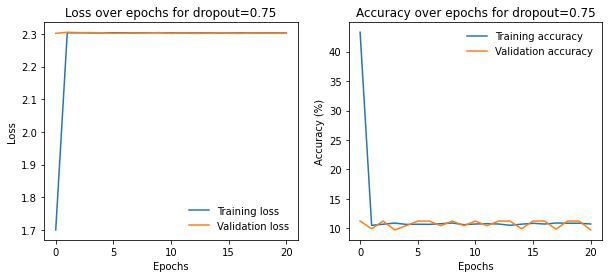

Test Accuracy: 9.82%


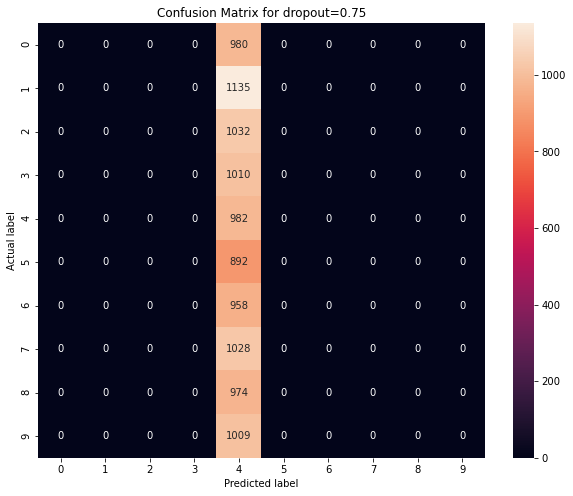

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN(Dropout=0.75).to(device)

optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.9)

early_stopping = EarlyStopping(patience=10)
loss = nn.CrossEntropyLoss()

train_losses     = []
val_losses       = []
train_accuracies = []
val_accuracies   = []
# Training loop
epochs = 100
for epoch in range(1, epochs + 1):
    train_loss, train_accuracy = train   (model, device, loss, train_loader, optimizer)
    val_loss, val_accuracy     = validate(model, device, loss, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f'Epoch: {epoch}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%')
    scheduler.step()
    
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break    


plt.figure(figsize=(10, 4))

# Plot for loss
plt.subplot(1, 2, 1)
plt.plot([i.detach().numpy() for i in train_losses], label='Training loss')
plt.plot([i.detach().numpy() for i in val_losses], label='Validation loss')
plt.legend(frameon=False)
plt.title('Loss over epochs for dropout=0.75')
plt.xlabel('Epochs')  # X-axis title
plt.ylabel('Loss')  # Y-axis title

# Plot for accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training accuracy')
plt.plot(val_accuracies, label='Validation accuracy')
plt.legend(frameon=False)
plt.title('Accuracy over epochs for dropout=0.75')
plt.xlabel('Epochs')  # X-axis title
plt.ylabel('Accuracy (%)')  # Y-axis title

plt.show()

# Test the model
test_loss, test_accuracy = validate(model, device, loss,  test_loader)
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Predictions and true labels
true_labels = []
pred_labels = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        output = model.softmax(output)
        pred = output.argmax(dim=1, keepdim=True).view_as(target)
        pred_labels.extend(pred.tolist())
        true_labels.extend(target.tolist())

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix for dropout=0.75')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


# Results

Implementing dropout with a rate of 0.75, the test results were unsatisfactory.

This dropout rate is overly aggressive, leading to significant loss of information within the network. With 0.75 of neurons dropped out during training, the network struggles to effectively learn. While a dropout rate of 0.75 is commonly used, it can sometimes be excessive, hindering the network's learning process.